In [1]:
!apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [2]:
!unrar x /content/Dataset.rar /content/Dataset



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Dataset.rar

No files to extract


In [3]:
!mkdir -p /content/Dataset


In [4]:
!unrar x -o+ /content/Dataset.rar /content/Dataset/



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Dataset.rar

Creating    /content/Dataset/Dataset                                  OK
Creating    /content/Dataset/Dataset/Testing                          OK
Creating    /content/Dataset/Dataset/Testing/fire                     OK
Extracting  /content/Dataset/Dataset/Testing/fire/abc001.jpg               0%  OK 
Extracting  /content/Dataset/Dataset/Testing/fire/abc002.jpg               0%  OK 
Extracting  /content/Dataset/Dataset/Testing/fire/abc003.jpg               0%  OK 
Extracting  /content/Dataset/Dataset/Testing/fire/abc004.jpg               0%  OK 
Extracting  /content/Dataset/Dataset/Testing/fire/abc005.jpg               0%  OK 
Extracting  /content/Dataset/Dataset/Testing/fire/abc006.jpg               0%  OK 
Extracting  /content/Dataset/Dataset/Testing/fire/abc007.jpg               0%  OK 
Extracting  /content/Da

In [5]:
import os

def count_images(path):
    count = 0
    for root, _, files in os.walk(path):
        count += len([f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    return count

base_path = "/content/Dataset/Dataset"

print("Train Fire:", count_images(f"{base_path}/Training and Validation/fire"))
print("Train No Fire:", count_images(f"{base_path}/Training and Validation/nofire"))
print("Test Fire:", count_images(f"{base_path}/Testing/fire"))
print("Test No Fire:", count_images(f"{base_path}/Testing/nofire"))



Train Fire: 760
Train No Fire: 760
Test Fire: 190
Test No Fire: 190


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_path = "/content/Dataset/Dataset"

source_dir = os.path.join(base_path, "Training and Validation")
split_dir = os.path.join(base_path, "splits")

classes = os.listdir(source_dir)  # this auto-detects fire / non-fire

for cls in classes:
    os.makedirs(f"{split_dir}/train/{cls}", exist_ok=True)
    os.makedirs(f"{split_dir}/val/{cls}", exist_ok=True)

    images = os.listdir(f"{source_dir}/{cls}")
    train_imgs, val_imgs = train_test_split(
        images, test_size=0.2, random_state=42
    )

    for img in train_imgs:
        shutil.copy(
            f"{source_dir}/{cls}/{img}",
            f"{split_dir}/train/{cls}/{img}"
        )

    for img in val_imgs:
        shutil.copy(
            f"{source_dir}/{cls}/{img}",
            f"{split_dir}/val/{cls}/{img}"
        )


In [7]:
!pip install albumentations opencv-python


In [8]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations import (
    Compose, Resize, HorizontalFlip, RandomBrightnessContrast
)
from albumentations.pytorch import ToTensorV2

class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for label, cls in enumerate(os.listdir(root_dir)):
            cls_path = os.path.join(root_dir, cls)
            for img in os.listdir(cls_path):
                self.samples.append((os.path.join(cls_path, img), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, torch.tensor(label, dtype=torch.float32)


In [9]:
from albumentations import (
    Compose, Resize, HorizontalFlip,
    RandomBrightnessContrast, Normalize
)
from albumentations.pytorch import ToTensorV2

train_transform = Compose([
    Resize(150, 150),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
    Normalize(mean=(0.485, 0.456, 0.406),
              std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [10]:
val_transform = Compose([
    Resize(150, 150),
    Normalize(mean=(0.485, 0.456, 0.406),
              std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [11]:
train_dataset = FireDataset(
    f"{base_path}/splits/train",
    transform=train_transform
)

val_dataset = FireDataset(
    f"{base_path}/splits/val",
    transform=val_transform
)

test_dataset = FireDataset(
    f"{base_path}/Testing",
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
images, labels = next(iter(train_loader))
print(images.dtype, images.min().item(), images.max().item())


torch.float32 -2.1179039478302 2.6399998664855957


In [13]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([32, 3, 150, 150]) torch.Size([32])


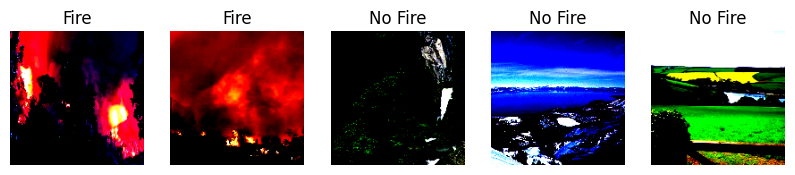

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("Fire" if labels[i] == 0 else "No Fire")
    plt.axis("off")
plt.show()


FireNet-CNN model implementation


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FireNetCNN(nn.Module):
    def __init__(self):
        super(FireNetCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [16]:
model = FireNetCNN()
dummy_input = torch.randn(1, 3, 150, 150)
output = model(dummy_input)

print("Output shape:", output.shape)


Output shape: torch.Size([1, 1])


In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Total parameters: 5,896,961


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [20]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(loader), accuracy


In [21]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


100%|██████████| 38/38 [02:00<00:00,  3.16s/it]


Epoch [1/40] Train Loss: 0.2402 | Val Loss: 0.1762 | Val Acc: 0.9408


100%|██████████| 38/38 [01:51<00:00,  2.93s/it]


Epoch [2/40] Train Loss: 0.1118 | Val Loss: 0.0799 | Val Acc: 0.9770


100%|██████████| 38/38 [01:59<00:00,  3.16s/it]


Epoch [3/40] Train Loss: 0.0949 | Val Loss: 0.0678 | Val Acc: 0.9770


100%|██████████| 38/38 [01:53<00:00,  2.99s/it]


Epoch [4/40] Train Loss: 0.0916 | Val Loss: 0.0836 | Val Acc: 0.9671


100%|██████████| 38/38 [01:52<00:00,  2.97s/it]


Epoch [5/40] Train Loss: 0.0645 | Val Loss: 0.0813 | Val Acc: 0.9737


100%|██████████| 38/38 [01:52<00:00,  2.95s/it]


Epoch [6/40] Train Loss: 0.0649 | Val Loss: 0.0779 | Val Acc: 0.9704


100%|██████████| 38/38 [01:52<00:00,  2.97s/it]


Epoch [7/40] Train Loss: 0.0597 | Val Loss: 0.0589 | Val Acc: 0.9770


100%|██████████| 38/38 [02:02<00:00,  3.22s/it]


Epoch [8/40] Train Loss: 0.0362 | Val Loss: 0.0732 | Val Acc: 0.9770


100%|██████████| 38/38 [01:53<00:00,  2.99s/it]


Epoch [9/40] Train Loss: 0.0694 | Val Loss: 0.0519 | Val Acc: 0.9803


100%|██████████| 38/38 [01:54<00:00,  3.01s/it]


Epoch [10/40] Train Loss: 0.0312 | Val Loss: 0.0645 | Val Acc: 0.9868


100%|██████████| 38/38 [01:53<00:00,  2.98s/it]


Epoch [11/40] Train Loss: 0.0312 | Val Loss: 0.0823 | Val Acc: 0.9770


100%|██████████| 38/38 [01:53<00:00,  3.00s/it]


Epoch [12/40] Train Loss: 0.0292 | Val Loss: 0.1244 | Val Acc: 0.9671


100%|██████████| 38/38 [02:01<00:00,  3.20s/it]


Epoch [13/40] Train Loss: 0.0408 | Val Loss: 0.0550 | Val Acc: 0.9868


100%|██████████| 38/38 [01:53<00:00,  2.98s/it]


Epoch [14/40] Train Loss: 0.0247 | Val Loss: 0.0841 | Val Acc: 0.9803


100%|██████████| 38/38 [01:53<00:00,  2.98s/it]


Epoch [15/40] Train Loss: 0.0375 | Val Loss: 0.0392 | Val Acc: 0.9934


100%|██████████| 38/38 [01:51<00:00,  2.95s/it]


Epoch [16/40] Train Loss: 0.0193 | Val Loss: 0.0396 | Val Acc: 0.9901


100%|██████████| 38/38 [01:53<00:00,  2.98s/it]


Epoch [17/40] Train Loss: 0.0117 | Val Loss: 0.0655 | Val Acc: 0.9901


100%|██████████| 38/38 [01:53<00:00,  3.00s/it]


Epoch [18/40] Train Loss: 0.0144 | Val Loss: 0.0604 | Val Acc: 0.9901


100%|██████████| 38/38 [01:53<00:00,  2.99s/it]


Epoch [19/40] Train Loss: 0.0193 | Val Loss: 0.1212 | Val Acc: 0.9770


100%|██████████| 38/38 [01:54<00:00,  3.00s/it]


Epoch [20/40] Train Loss: 0.0517 | Val Loss: 0.0820 | Val Acc: 0.9836


100%|██████████| 38/38 [01:54<00:00,  3.01s/it]


Epoch [21/40] Train Loss: 0.0253 | Val Loss: 0.0429 | Val Acc: 0.9901


100%|██████████| 38/38 [01:54<00:00,  3.01s/it]


Epoch [22/40] Train Loss: 0.0213 | Val Loss: 0.0564 | Val Acc: 0.9868


100%|██████████| 38/38 [01:54<00:00,  3.01s/it]


Epoch [23/40] Train Loss: 0.0159 | Val Loss: 0.0577 | Val Acc: 0.9901


100%|██████████| 38/38 [01:54<00:00,  3.01s/it]


Epoch [24/40] Train Loss: 0.0064 | Val Loss: 0.0519 | Val Acc: 0.9901


100%|██████████| 38/38 [01:54<00:00,  3.01s/it]


Epoch [25/40] Train Loss: 0.0151 | Val Loss: 0.0482 | Val Acc: 0.9901


100%|██████████| 38/38 [01:56<00:00,  3.08s/it]


Epoch [26/40] Train Loss: 0.0367 | Val Loss: 0.0679 | Val Acc: 0.9836


100%|██████████| 38/38 [01:55<00:00,  3.03s/it]


Epoch [27/40] Train Loss: 0.0271 | Val Loss: 0.0429 | Val Acc: 0.9868


100%|██████████| 38/38 [01:55<00:00,  3.03s/it]


Epoch [28/40] Train Loss: 0.0175 | Val Loss: 0.0440 | Val Acc: 0.9803


100%|██████████| 38/38 [01:54<00:00,  3.02s/it]


Epoch [29/40] Train Loss: 0.0139 | Val Loss: 0.0347 | Val Acc: 0.9901


100%|██████████| 38/38 [01:54<00:00,  3.01s/it]


Epoch [30/40] Train Loss: 0.0212 | Val Loss: 0.0183 | Val Acc: 0.9934


100%|██████████| 38/38 [01:54<00:00,  3.00s/it]


Epoch [31/40] Train Loss: 0.0215 | Val Loss: 0.0444 | Val Acc: 0.9868


100%|██████████| 38/38 [01:53<00:00,  3.00s/it]


Epoch [32/40] Train Loss: 0.0139 | Val Loss: 0.0343 | Val Acc: 0.9901


100%|██████████| 38/38 [01:53<00:00,  2.99s/it]


Epoch [33/40] Train Loss: 0.0201 | Val Loss: 0.0437 | Val Acc: 0.9934


100%|██████████| 38/38 [01:53<00:00,  2.99s/it]


Epoch [34/40] Train Loss: 0.0134 | Val Loss: 0.0588 | Val Acc: 0.9868


100%|██████████| 38/38 [01:53<00:00,  3.00s/it]


Epoch [35/40] Train Loss: 0.0186 | Val Loss: 0.0634 | Val Acc: 0.9901


100%|██████████| 38/38 [01:54<00:00,  3.02s/it]


Epoch [36/40] Train Loss: 0.0053 | Val Loss: 0.0527 | Val Acc: 0.9836


100%|██████████| 38/38 [01:53<00:00,  3.00s/it]


Epoch [37/40] Train Loss: 0.0038 | Val Loss: 0.0467 | Val Acc: 0.9836


100%|██████████| 38/38 [01:54<00:00,  3.02s/it]


Epoch [38/40] Train Loss: 0.0173 | Val Loss: 0.0486 | Val Acc: 0.9901


100%|██████████| 38/38 [01:53<00:00,  3.00s/it]


Epoch [39/40] Train Loss: 0.0077 | Val Loss: 0.0540 | Val Acc: 0.9836


100%|██████████| 38/38 [01:54<00:00,  3.02s/it]


Epoch [40/40] Train Loss: 0.0061 | Val Loss: 0.0498 | Val Acc: 0.9836


In [22]:
torch.save(model.state_dict(), "firenet_cnn.pth")
print("Model saved as firenet_cnn.pth")


Model saved as firenet_cnn.pth


Evaluate on the TEST set


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_test(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)

            y_pred.extend(preds.flatten())
            y_true.extend(labels.numpy())

    return y_true, y_pred


y_true, y_pred = evaluate_test(model, test_loader)

print("Test Accuracy :", accuracy_score(y_true, y_pred))
print("Precision     :", precision_score(y_true, y_pred))
print("Recall        :", recall_score(y_true, y_pred))
print("F1 Score      :", f1_score(y_true, y_pred))


Test Accuracy : 0.9447368421052632
Precision     : 0.9203980099502488
Recall        : 0.9736842105263158
F1 Score      : 0.9462915601023018


Confusion Matrix

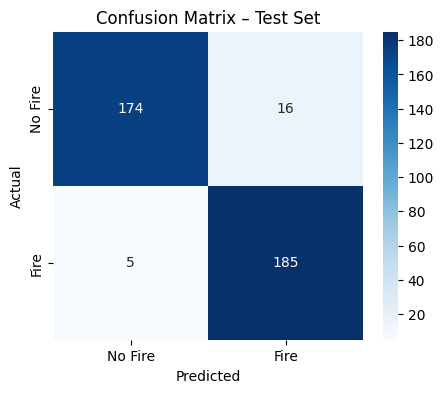

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fire", "Fire"],
            yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Test Set")
plt.show()


Grad-CAM implementation

In [25]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image):
        self.model.zero_grad()
        output = self.model(input_image)
        score = torch.sigmoid(output[:, 0])
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam


In [26]:
for idx, layer in enumerate(model.features):
    print(idx, layer)


0 Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 ReLU()
3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
4 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
6 ReLU()
7 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
8 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
10 ReLU()
11 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
12 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
14 ReLU()
15 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
16 Conv2d(256, 512, kernel_size=(3, 3), stride

In [27]:
gradcam = GradCAM(model, model.features[12])  # Conv2d(128 → 256)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


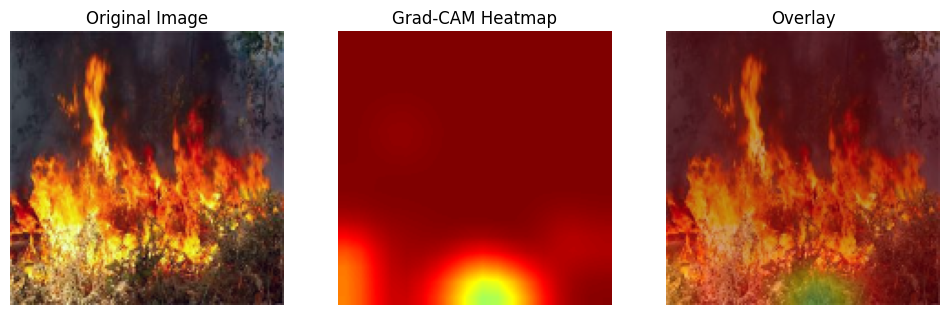

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

model.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

cam = gradcam.generate(images[:1])
cam = cam.cpu().detach().numpy()[0]
cam = cv2.GaussianBlur(cam, (7, 7), 0)

img = images[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = 0.6 * img + 0.4 * heatmap / 255

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


for gradecam on random image


/tmp/ipython-input-1031124263.py:26: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


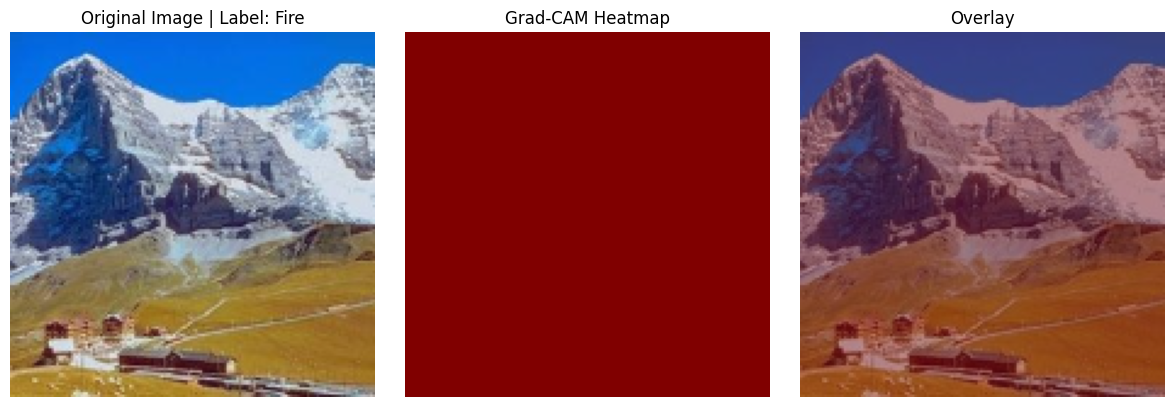

In [29]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

model.eval()

# --- Pick a RANDOM image from the test dataset ---
dataset = test_loader.dataset
idx = random.randint(0, len(dataset) - 1)

image, label = dataset[idx]
image = image.unsqueeze(0).to(device)

# --- Generate Grad-CAM ---
cam = gradcam.generate(image)
cam = cam.cpu().detach().numpy()[0]
cam = cv2.GaussianBlur(cam, (7, 7), 0)

# --- Prepare original image for display ---
img = image[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

# --- Create heatmap and overlay ---
heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

overlay = 0.6 * img + 0.4 * heatmap / 255

# --- Plot ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f"Original Image | Label: {'Fire' if label == 1 else 'No Fire'}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [30]:
model.eval()

cases = {
    "TP": None,
    "TN": None,
    "FP": None,
    "FN": None
}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)

        for i in range(len(labels)):
            y = labels[i].item()
            p = preds[i][0]

            if y == 1 and p == 1 and cases["TP"] is None:
                cases["TP"] = images[i:i+1]
            elif y == 0 and p == 0 and cases["TN"] is None:
                cases["TN"] = images[i:i+1]
            elif y == 0 and p == 1 and cases["FP"] is None:
                cases["FP"] = images[i:i+1]
            elif y == 1 and p == 0 and cases["FN"] is None:
                cases["FN"] = images[i:i+1]

        if all(v is not None for v in cases.values()):
            break


In [31]:
img_tensor = cases["TP"]   # shape: [1, 3, 150, 150]


In [32]:
cam = gradcam.generate(img_tensor)
cam = cam.cpu().detach().numpy()[0]
cam = cv2.GaussianBlur(cam, (7, 7), 0)


In [33]:
img = img_tensor[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())


In [34]:
heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

overlay = 0.6 * img + 0.4 * heatmap / 255


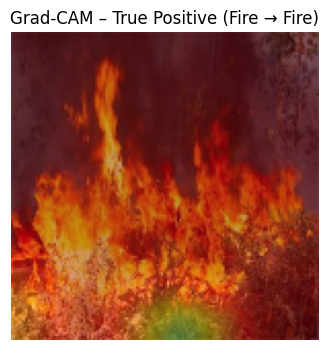

In [41]:
plt.figure(figsize=(6, 4))
plt.imshow(overlay)
plt.title("Grad-CAM – True Positive (Fire → Fire)")
plt.axis("off")
plt.show()

overlay_clipped = np.clip(overlay, 0, 1)
plt.imsave("gradcam_TP.png", overlay_clipped)


In [49]:
img_tensor = cases["TN"]


In [50]:
cam = gradcam.generate(img_tensor)
cam = cam.cpu().detach().numpy()[0]
cam = cv2.GaussianBlur(cam, (7, 7), 0)


In [51]:
img = img_tensor[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())


In [52]:
heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

overlay = 0.6 * img + 0.4 * heatmap / 255


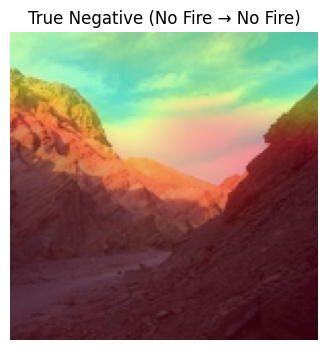

In [64]:
plt.figure(figsize=(6, 4))
plt.imshow(overlay)
plt.title("True Negative (No Fire → No Fire)")
plt.axis("off")
plt.show()

overlay_clipped = np.clip(overlay, 0, 1)
plt.imsave("gradcam_TN.png", overlay_clipped)


In [54]:
img_tensor = cases["FP"]


In [55]:
cam = gradcam.generate(img_tensor)
cam = cam.cpu().detach().numpy()[0]
cam = cv2.GaussianBlur(cam, (7, 7), 0)


In [56]:
cam = gradcam.generate(img_tensor)
cam = cam.cpu().detach().numpy()[0]
cam = cv2.GaussianBlur(cam, (7, 7), 0)


In [57]:
heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

overlay = 0.6 * img + 0.4 * heatmap / 255


/tmp/ipython-input-1773441198.py:2: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


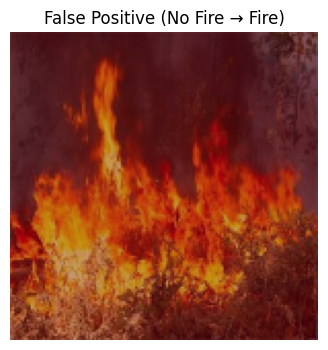

In [58]:
plt.figure(figsize=(6, 4))
plt.imshow(overlay)
plt.title("False Positive (No Fire → Fire)")
plt.axis("off")
plt.show()

overlay_clipped = np.clip(overlay, 0, 1)
plt.imsave("gradcam_FP.png", overlay_clipped)


In [59]:
img_tensor = cases["FN"]


In [60]:
cam = gradcam.generate(img_tensor)
cam = cam.cpu().detach().numpy()[0]
cam = cv2.GaussianBlur(cam, (7, 7), 0)


In [61]:
img = img_tensor[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())


In [62]:
heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

overlay = 0.6 * img + 0.4 * heatmap / 255


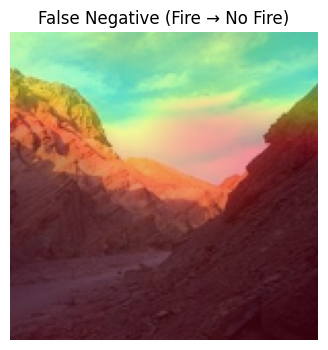

In [63]:
plt.figure(figsize=(6, 4))
plt.imshow(overlay)
plt.title("False Negative (Fire → No Fire)")
plt.axis("off")
plt.show()

overlay_clipped = np.clip(overlay, 0, 1)
plt.imsave("gradcam_FN.png", overlay_clipped)
